# Variational Autoencoder 

## import library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
 
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

Tahapan yang perlu Anda lakukan adalah menyiapkan parameter dasar yang akan digunakan kelak

In [2]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5
BETA = 500

mengunduh dataset yang akan digunakan. Karena pada kasus ini menggunakan fashion mnist

In [3]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## preprocessing terhadap data latih dan data uji

In [4]:
def preprocess(imgs):
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs
 
x_train = preprocess(x_train)
x_test = preprocess(x_test)

buatlah sebuah kelas Sampling layer yang bertugas untuk menghitung distribusi data berdasarkan z_mean dan z_log_var.

In [5]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

* class Sampling(layers.Layer): baris ini mendeklarasikan sebuah class bernama Sampling yang mewarisi dari class layers.Layer di TensorFlow. Ini menandakan bahwa Sampling adalah sebuah lapisan kustom yang bisa kita gunakan dalam model kita.
* def call(self, inputs): method call ini didefinisikan untuk menentukan bagaimana lapisan ini memproses input dan menghasilkan output. Fungsi call ini akan dipanggil setiap kali lapisan ini digunakan dalam model.
* z_mean, z_log_var = inputs: baris ini mengambil input dari lapisan sebelumnya. Biasanya dalam VAE, input akan terdiri dari dua tensor:
* z_mean: merepresentasikan mean (rata-rata) dari latent space.
* z_log_var: merepresentasikan log variance (log varians) dari latent space.
* batch = tf.shape(z_mean)[0]: menyimpan jumlah sampel dalam batch.
* dim = tf.shape(z_mean)[1]: menyimpan dimensi dari latent space (biasanya jumlah neuron di lapisan latent).
* epsilon = K.random_normal(shape=(batch, dim)): baris ini menggunakan fungsi K.random_normal dari library Keras untuk menghasilkan noise acak. Noise ini berdistribusi normal dengan mean 0 dan variance 1. Sedangkan shape=(batch, dim) memastikan noise memiliki ukuran yang sama dengan z_mean dan z_log_var.
* tf.exp(0.5 * z_log_var): digunakan untuk menghitung standard deviation dari latent space karena varians bernilai kuadrat dari standar deviasi.
epsilon * standard_deviation: menambahkan noise acak yang sudah diskalakan oleh standar deviasi ke z_mean.

Selanjutnya, mari kita membuat jaringan saraf tiruan yang bertugas untuk melakukan encoding dan decoding.

In [6]:
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, 1), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  
 
x = layers.Flatten()(x)
z_mean = layers.Dense(EMBEDDING_DIM, name="z_mean")(x)
z_log_var = layers.Dense(EMBEDDING_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
 
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)
 
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

Setelah model rampung dibuat tentunya kita perlu melakukan pelatihan, tetapi VAE belum memiliki library pendukung layaknya deep learning lainnya. Oleh karena itu, mari kita buat sebuah kelas VAE yang merupakan turunan dari models TensorFlow.

In [8]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")
 
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
 
    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction
 
    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss
 
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
 
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
 
        return {m.name: m.result() for m in self.metrics}
 
    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]
 
        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss
 
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [10]:
vae = VAE(encoder, decoder)
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)
 
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint.weights.h5",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")
 
vae.fit(
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - kl_loss: 3.6131 - reconstruction_loss: 195.1142 - total_loss: 198.7272

c:\Users\espej\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:276: UserWarning: Can save best model only with loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


600/600 ━━━━━━━━━━━━━━━━━━━━ 52s 81ms/step - kl_loss: 4.3276 - reconstruction_loss: 156.2168 - total_loss: 160.5442 - val_kl_loss: 4.8440 - val_loss: 141.0731 - val_reconstruction_loss: 136.2291
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - kl_loss: 4.9263 - reconstruction_loss: 131.1736 - total_loss: 136.1000

600/600 ━━━━━━━━━━━━━━━━━━━━ 48s 80ms/step - kl_loss: 4.9554 - reconstruction_loss: 130.3299 - total_loss: 135.2854 - val_kl_loss: 4.9268 - val_loss: 137.9938 - val_reconstruction_loss: 133.0670
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - kl_loss: 5.0356 - reconstruction_loss: 129.0166 - total_loss: 134.0522

600/600 ━━━━━━━━━━━━━━━━━━━━ 57s 95ms/step - kl_loss: 5.0593 - reconstruction_loss: 128.6255 - total_loss: 133.6848 - val_kl_loss: 5.2535 - val_loss: 136.2697 - val_reconstruction_loss: 131.0162
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - kl_loss: 5.1213 - reconstruction_loss: 127.7779 - total_loss: 132.8991

600/600 ━━━━━━━━━━━━━━━━━━━━ 53s 88ms/step - kl_loss: 5.1206 - reconstruction_loss: 127.7169 - total_loss: 132.8374 - val_kl_loss: 5.2917 - val_loss: 135.7120 - val_reconstruction_loss: 130.4203
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - kl_loss: 5.1624 - reconstruction_loss: 127.2309 - total_loss: 132.3933

600/600 ━━━━━━━━━━━━━━━━━━━━ 57s 94ms/step - kl_loss: 5.1742 - reconstruction_loss: 127.2086 - total_loss: 132.3828 - val_kl_loss: 5.4210 - val_loss: 135.3257 - val_reconstruction_loss: 129.9046


Untuk menguji model VAE, kita dapat melakukan test yang dapat menghasilkan gambar berdasarkan ruang laten yang telah dibuat. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


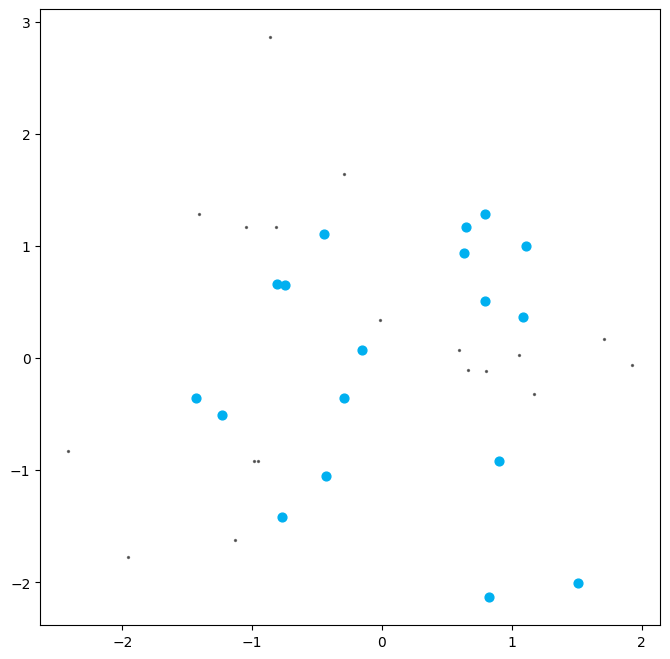

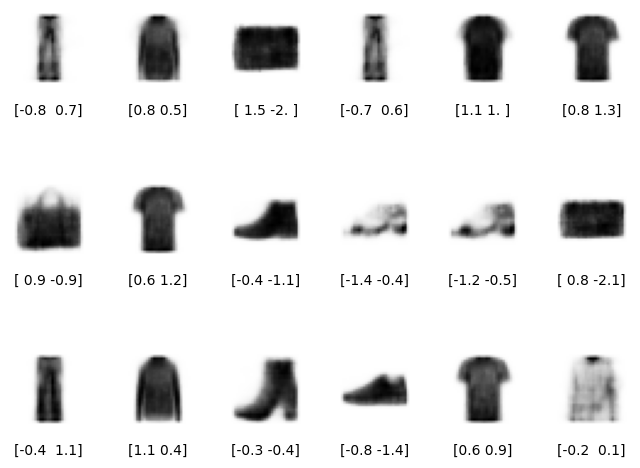

In [17]:
# Encode citra
z_mean, z_var, z = encoder.predict(example_images)
 
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))
 
# Decode sampel poin
reconstructions = decoder.predict(z_sample)
 
# Konversi nilai embedding menjadi p_values
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)
 
# Membuat plot
figsize = 8
plt.figure(figsize=(figsize, figsize))
 
# Original Embeddings
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)
 
# Ruang laten
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()
 
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
 
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")